# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025

In [119]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scipy
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import seaborn as sns



**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

In this exercise, we revisit and extend the concepts from Week 9, focusing on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE), similar to our previous approach but with a key difference: we now incorporate **time-dependent** transcription and degradation rates to model circadian rhythms.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is defined by $\omega=\frac{2\pi}{T}$ with $T=24h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).  

3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhyhtmic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$). 
    


Question 1)

In [120]:
# Define the ODEs
def circadian_ode(t, y, s0, k0, es, ek, omega, tk, rho):
    P, M = y
    # Define time-dependent transcription and degradation rates
    s_t = s0 * (1 + es * np.cos(omega * t))  # Transcription rate
    k_t = k0 * (1 + ek * np.cos(omega * (t - tk)))  # Degradation rate
    
    # ODEs
    dPdt = s_t - rho * P
    dMdt = rho * P - k_t * M
    return [dPdt, dMdt]

In [121]:
from scipy.integrate import solve_ivp

In [122]:
# Simulation function
def circadian_simulation(parameters, initial_conditions, time):
    # Unpack parameters
    s0 = parameters['s0']
    k0 = parameters['k0']
    es = parameters['es']
    ek = parameters['ek']
    omega = parameters['omega']
    tk = parameters['tk']
    rho = parameters['rho']
    
    # Solve the ODE
    solution = solve_ivp(circadian_ode, [time[0], time[-1]], initial_conditions, 
                         args=(s0, k0, es, ek, omega, tk, rho), 
                         t_eval=time, rtol=1e-6, atol=1e-8)
    
    return solution.t, solution.y

In [123]:
# Plot function
def plot_results(time, results):
    P, M = results
    plt.figure(figsize=(10, 6))
    plt.plot(time, P, label='P(t) (pre-mRNA)', linewidth=2)
    plt.plot(time, M, label='M(t) (mRNA)', linewidth=2)
    plt.title('Circadian Gene Regulation')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()

In [124]:
# Interactive animation function
def animate(initial_conditions, time, s0=5, k0=0.05, es=0.5, ek=0, omega=2*np.pi/24, tk=0, rho=0.4):
    parameters = {
        's0': s0,
        'k0': k0,
        'es': es,
        'ek': ek,
        'omega': omega,
        'tk': tk,
        'rho': rho
    }
    time, results = circadian_simulation(parameters, initial_conditions, time)
    plot_results(time, results)

In [ ]:
# Define initial conditions and time intervals
initial_conditions = [0, 0]  # [P, M]
time = np.linspace(0, 100, 5001)  # Simulate for 100 hours with 5001 time points

# Run the interactive widget
# The parameters are already in the form 1/time
interact(animate,
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time),
         s0=(1, 10, 0.1),  # Transcription rate
         k0=(0.01, 0.2, 0.01),  # Base degradation rate
         es=(0, 1, 0.1),  # Amplitude of rhythmic transcription
         ek=(0, 1, 0.1),  # Amplitude of rhythmic degradation
         omega=fixed(2 * np.pi / 24),  # Circadian frequency
         tk=(0, 24, 1),  # Time shift for degradation peak
         rho=(0.1, 1, 0.1));  # Splicing rate

interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=1.0), FloatSlider(value=0.05, des…

## Answers 
Question 2)
k0 directly controls the degradation of mRNA. By decreasing k0, we slow down the degradation rate allowing the concentration of mRNA M(t) to increase. Conversely, if we increase k0, it accelerates M(t) degradation (decreasing the concentration). 

Concerning the phase delay between pre-mRNA P(t) and mRNA M(t), increasing k0 reduces the phase delay as mRNA is cleared more rapidly, allowing M(t) to more closely follow the production dynamics of pre-mRNA P(t). 

Additionally, the amplitude of M(t), measured as the ratio between its maximum and minimum values, decreases with higher k0 because faster degradation limits the accumulation of mRNA. Conversely, lower k0 results in larger amplitude as mRNA persists longer and accumulates more significantly as the oscillations are flattened.

To sum up : 
- A high k0, implies a faster degradation rate for M(t), which means that mRNA is cleared faster and doesnt accumulate, leading to more burst of transcription s(t) to be reflected as seen in clearer oscillations of P(t). This can be observed by enhanced oscillations in both M(t) and P(t).
- A low k0, implies a slower degradation of mRNA, leading it to accumulate over time, dampening the oscillations resulting in an almost linear curve.

On the other hand, es is the amplitude of rhythmic transcription and doesn't affect the overall concentration but instead controls the oscillatory behavior of the transcription, impacting both M(t) and P(t).
- Increasing es leads to oscillations with greater amplitude and represents systems with strong circadian transcriptional rhythms. Conversely, lowering it dampens the oscillation and represents weaker transcriptional rhythms.
- When $es=0$ the transcription rate is constant over time : $s(t) = s0$. Consequently we see no oscillations in neither M(t) nor P(t). P(t) rapidly reached a plateau phase and M(t) almost follows a linear increase. This scenario represents a non circadian rhythm.

Question 3)
Keeping a constant synthesis $s(t) = s0$ by setting $es = 0$, we introduce a rhythmic degradation by varying ek. Since the synthesis is constant we shouldnt observe oscillatory behavior. However by increasing ek we can see M(t) starting to oscillate while P(t) remains the same, in a plateau state. The fact that varying ek doesnt impact P(t) is normal as ek is only associated with mRNA degradation, introducing oscillations via the degradation rate k(t).

Indeed, when $e_k \neq 0$, the degradation rate k(t) becomes time dependent and oscillates. 
- k(t) reaches a maximum when $\cos(\omega \cdot (t - t_k)) = 1$ causing mRNA to degrade faster.
- k(t) reaches a minimum when $\cos(\omega \cdot (t - t_k)) = - 1$ causing mRNA to remain longer.

The higher the value of ek, the clearer and more pronounced the peaks in M(t) become, as the rhythmic degradation introduces distinct periods of accumulation and clearance.

This setup represents a scenario where circadian regulation is driven by post-transcriptional mechanisms, such as rhythmic turnover of mRNA. This mechanism allows cells to synchronize specific gene expressions with environmental cycle even when the transcription rate is steady.

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver and muscle

In this exercise, we will analyze RNA-seq data from mouse liver and muscle under a night-restricted feeding regimen and in the presence of a 12-hour light-dark cycle. The samples were harvested every 2 hours around the clock, with higher resolution around the fasting-feeding transition (ZT12), in two replicates. Similar to the Week 9 exercises on RNA-seq data, gene expression was quantified at the intron (i.e., unspliced) and exon (i.e., spliced) levels. Note that the data are $log_2$-transformed and normalized by transcript length (RPKM, Reads Per Kilobase per Million mapped reads).

### Function definition

In [126]:
def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data

        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    if color_by=='time':
        pca_df[color_by] = pd.to_numeric(data_tmp.columns.get_level_values(color_by))
        palette='twilight'
    else:
        pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
        palette='Set1'
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        axes[i].set_box_aspect(1) 
        # remove legend if it's not the first plot
        if i == 0:
        # Move legend outside for the first plot
            axes[i].legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, title=color_by)
        else:
        # Remove legend for all other plots
            axes[i].get_legend().remove()
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)
    plt.tight_layout()
    
    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

def subselect(data, feature = None, replicate = None, time = None, condition = None):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The conditions to include (e.g, ['muscle', 'liver']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion
    if feature is None:
        feature = data.columns.get_level_values('feature').unique()
    if replicate is None:
        replicate = data.columns.get_level_values('replicate').unique()
    if time is None:
        time = data.columns.get_level_values('time').unique()
    if condition is None:
        condition = data.columns.get_level_values('condition').unique()

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    condition_mask  = data.columns.get_level_values('condition').isin(condition)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)

    # Use the masks to filter the data
    filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask]
    
    return filtered_data

def harm_reg(x, t, period):
    """
    Fit a harmonic regression model to a time series. Perform likelihood ratio test between the full and null model. Get p-value from the test.
    
    Parameters:
    x (array): Time series data
    t (array): Time points
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms)

    Returns:
    tuple: Mean (mu), peak-to-through amplitude (amp), phase (phase), and p-value (p_val)

    """

    n = len(x)
    
    # Fit the null model (intercept only)
    X0 = np.ones((n, 1))  # Design matrix for the null model
    fit0 = sm.OLS(x, X0).fit()
    
    c = np.cos(2 * np.pi * t / period)
    s = np.sin(2 * np.pi * t / period)
    
    # Design matrix for the full model
    X1 = np.column_stack((np.ones(n), c, s))
    fit1 = sm.OLS(x, X1).fit()
    
    # Coefficients
    mu = fit1.params[0]
    a = fit1.params[1]
    b = fit1.params[2]
    
    # Likelihood ratio test
    lr_stat = 2 * (fit1.llf - fit0.llf)
    p_val = scipy.stats.chi2.sf(lr_stat, 2)
    
    # Amplitude and phase
    amp = 2 * np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a) % (2 * np.pi)
    phase = period * phase / (2 * np.pi)

    
    return mu, amp, phase, p_val

def fit_harmo(data, time, period):
    """
    Applies the harm_reg function to all genes for a given normalized gene expression dataset.

    Parameters:
    data (pd.DataFrame): Normalized gene expression dataset with genes as rows.
    time (array): Time points for the dataset.
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms).

    Returns:
    pd.DataFrame: A DataFrame containing the amplitude, phase, p-value, qvalue and mu for each gene.
    """
    results = data.apply(lambda x: harm_reg(x.values, time, period), axis=1)
    results_df = pd.DataFrame(results.tolist(), index=data.index, columns=['mu', 'amp', 'phase', 'p_val'])
    results_df['p_val'] = results_df['p_val'].fillna(1)
    results_df['q_val'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    return results_df


# Plotting function for side-by-side liver and muscle plots
def plot_gene_expression(dat_melted, gene_name, title=None):
    """
    Plots the expression of a gene in liver and muscle over time.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['gene.symb'] == gene_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns
    
    # Plot Liver
    sns.scatterplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[0]
    )
    sns.lineplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[0]
    )
    axes[0].set_title(f"{gene_name} Expression in Liver")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Expression Level")
    axes[0].grid(alpha=0.3)
    axes[0].set_box_aspect(1)  # Ensure square aspect ratio

    # Plot Muscle
    sns.scatterplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[1]
    )
    sns.lineplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[1]
    )
    axes[1].set_title(f"{gene_name} Expression in Muscle")
    axes[1].set_xlabel("Time (hours)")
    axes[1].grid(alpha=0.3)
    axes[1].set_box_aspect(1)  # Ensure square aspect ratio

    if title:
        fig.suptitle(title)
    
    plt.show()

### Question 1

1. Perform PCA using the following 15 genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp', 'Ciart']``.  
Start by analyzing only the exons, then focus on the introns, for liver and muscle tissues separately.

2. Use the *fit_harmo* (i.e. harmonic regression) function on the data to assess and characterize genome-wide gene expression rhythmicity. Perform this analysis separately for the exons and introns, as well as for the muscle and liver tissues.

- Select rhythmic genes based on q-value thresholds (e.g., $q < 0.05$) and amplitude thresholds (e.g., $log_2$ peak-to-trough > 0.5) for further analysis.
- Provide histograms of the peak times (i.e. phase) and amplitudes ($log_2$ peak-to-trough) for the selected genes.
- Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
- Compare your observations between liver and muscle tissues.



#### Load the RNA-seq data

In [127]:
dat = pd.read_csv("./log2_RPKM_Liver_Muscle_Intron_Exon.tsv",sep='\t')
dat.index = dat['gene.symb']
dat = dat.drop(['gene.symb'], axis=1)
dat.columns = dat.columns.str.replace('ZT','') # remove ZT from time
dat.columns = dat.columns.str.split('_', expand = True) # split columns by '_'
dat.columns.names = ['feature','condition','time','replicate'] # name the columns, multi-index

# Calculate the mean expression in liver and muscle
mean_liver = dat.xs('liver', level='condition', axis=1).mean(axis=1)
mean_muscle = dat.xs('muscle', level='condition', axis=1).mean(axis=1)

# Filter out lowly expressed genes
dat = dat[(mean_liver >= -4) & (mean_muscle >= -4)]

#melting the data for plotting later
dat_melted = dat.stack(level=[0, 1, 2, 3]).reset_index()
dat_melted.columns = ['gene.symb', 'feature', 'condition', 'time', 'replicate', 'expression']
dat_melted['time'] = dat_melted['time'].str.extract(r'(\d+)').astype(int)


# Subset the data for liver and muscle, intron and exon
dat_intron_liver = subselect(dat, feature = ['Intron'], condition = ['liver'])
dat_exon_liver = subselect(dat, feature = ['Exon'], condition = ['liver'])
dat_intron_muscle = subselect(dat, feature = ['Intron'], condition = ['muscle'])
dat_exon_muscle = subselect(dat, feature = ['Exon'], condition = ['muscle'])


#### Perform the PCA on clock related genes

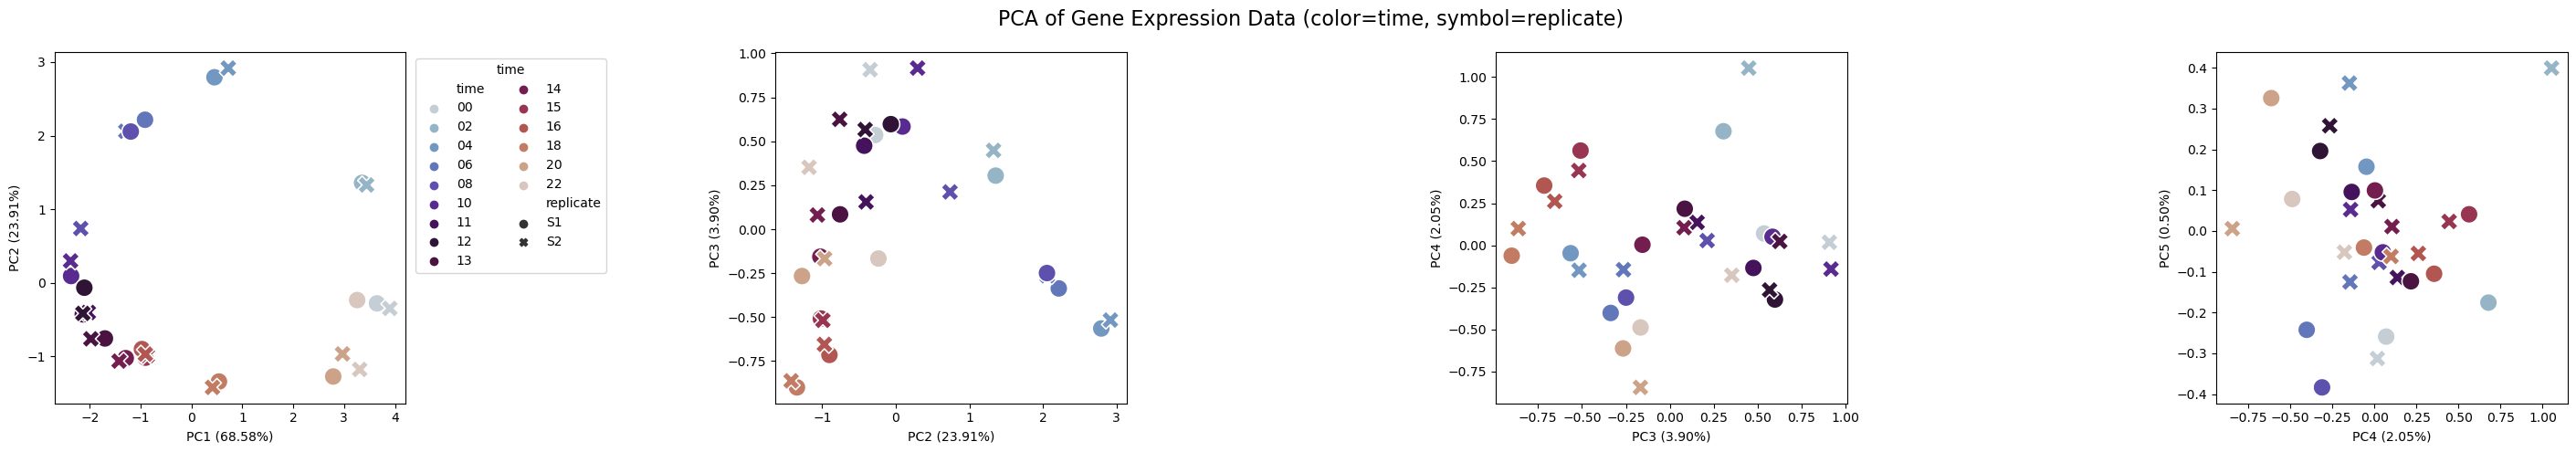

In [128]:
circa_genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp','Ciart']

pca_liver_exon = run_PCA(dat_exon_liver.loc[circa_genes], color_by='time', symbol_by='replicate')




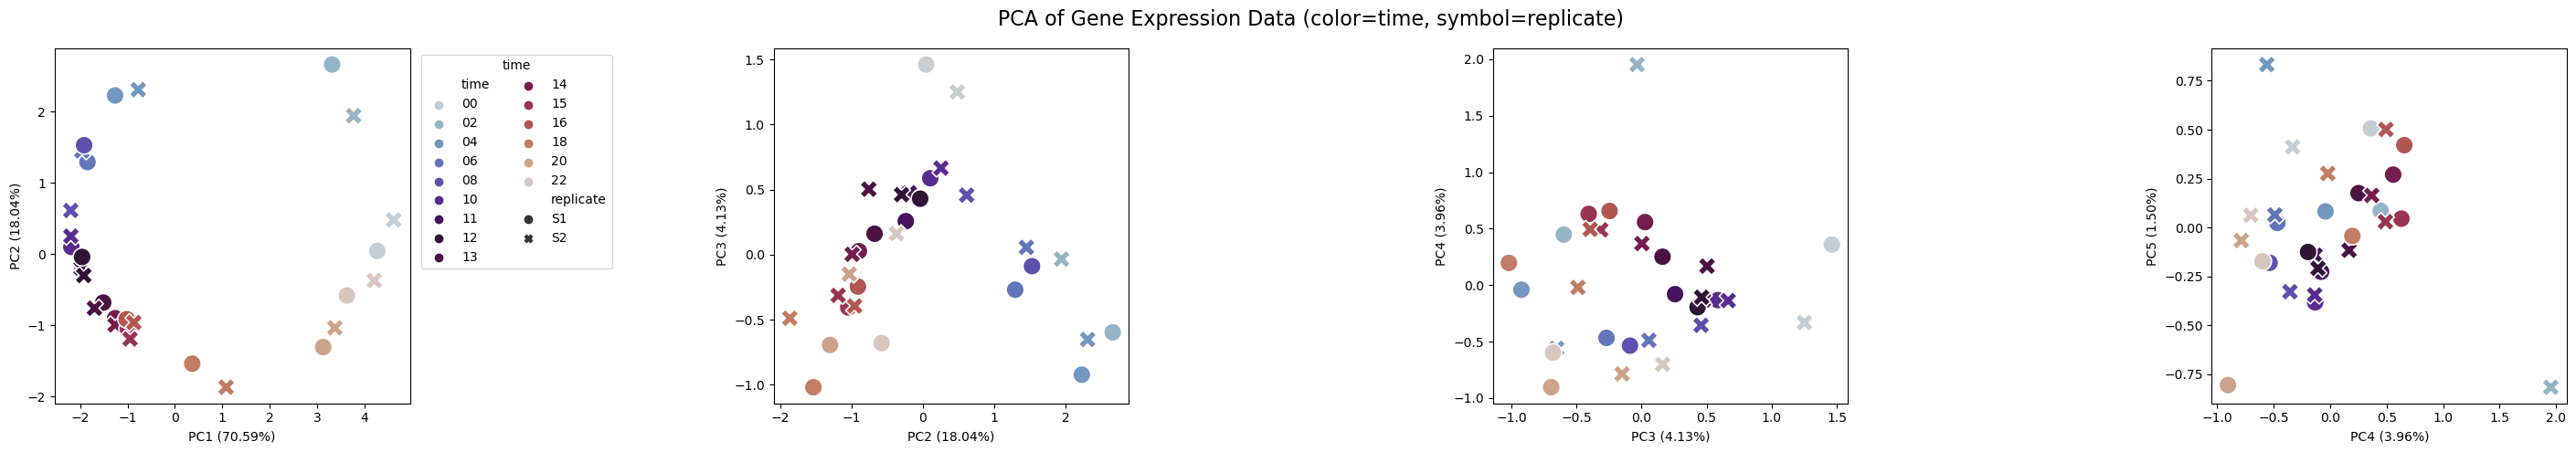

In [129]:
pca_liver_intron = run_PCA(dat_intron_liver.loc[circa_genes], color_by='time', symbol_by='replicate') 

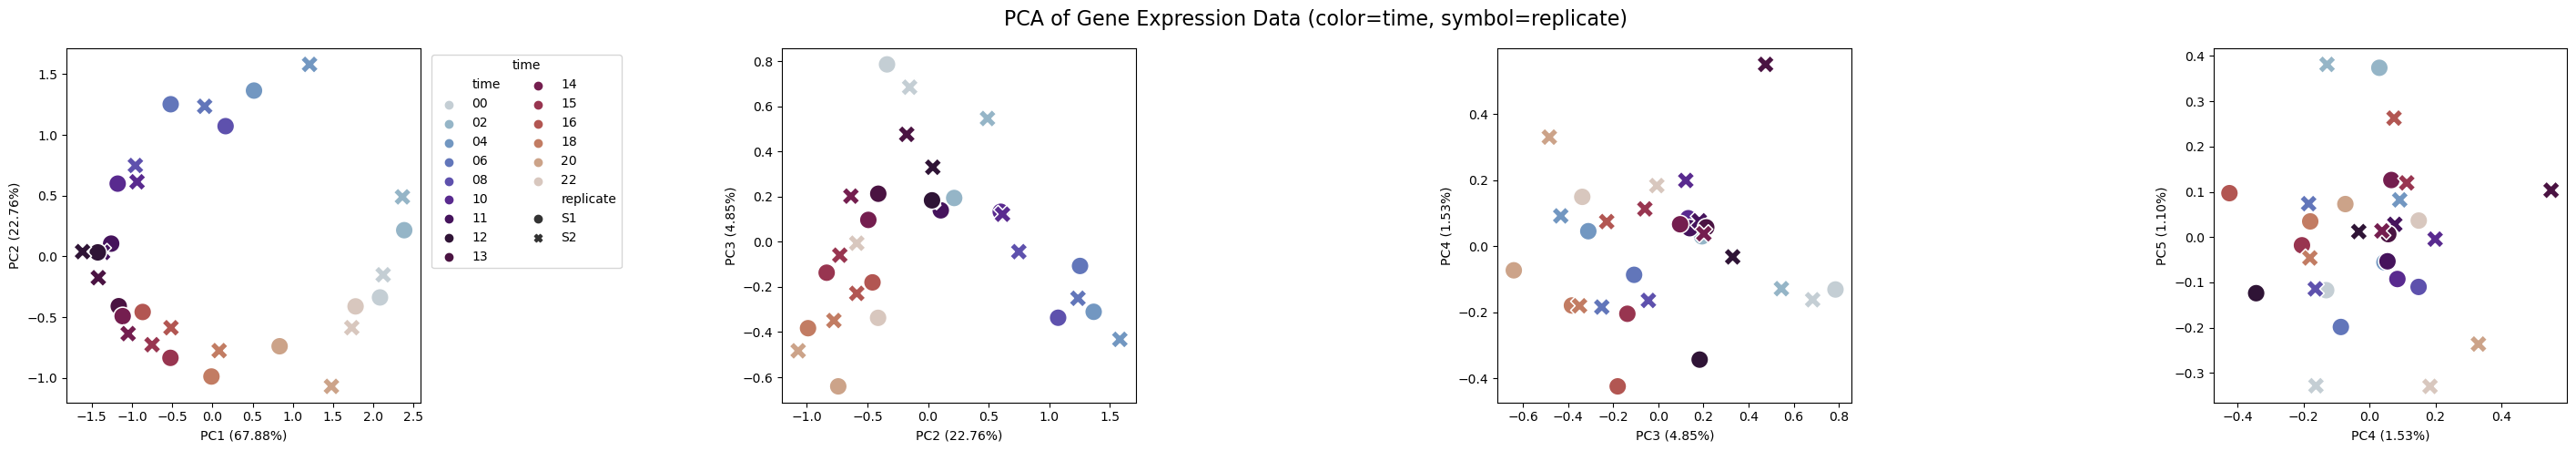

In [130]:
pca_muscle_exon = run_PCA(dat_exon_muscle.loc[circa_genes], color_by='time', symbol_by='replicate')

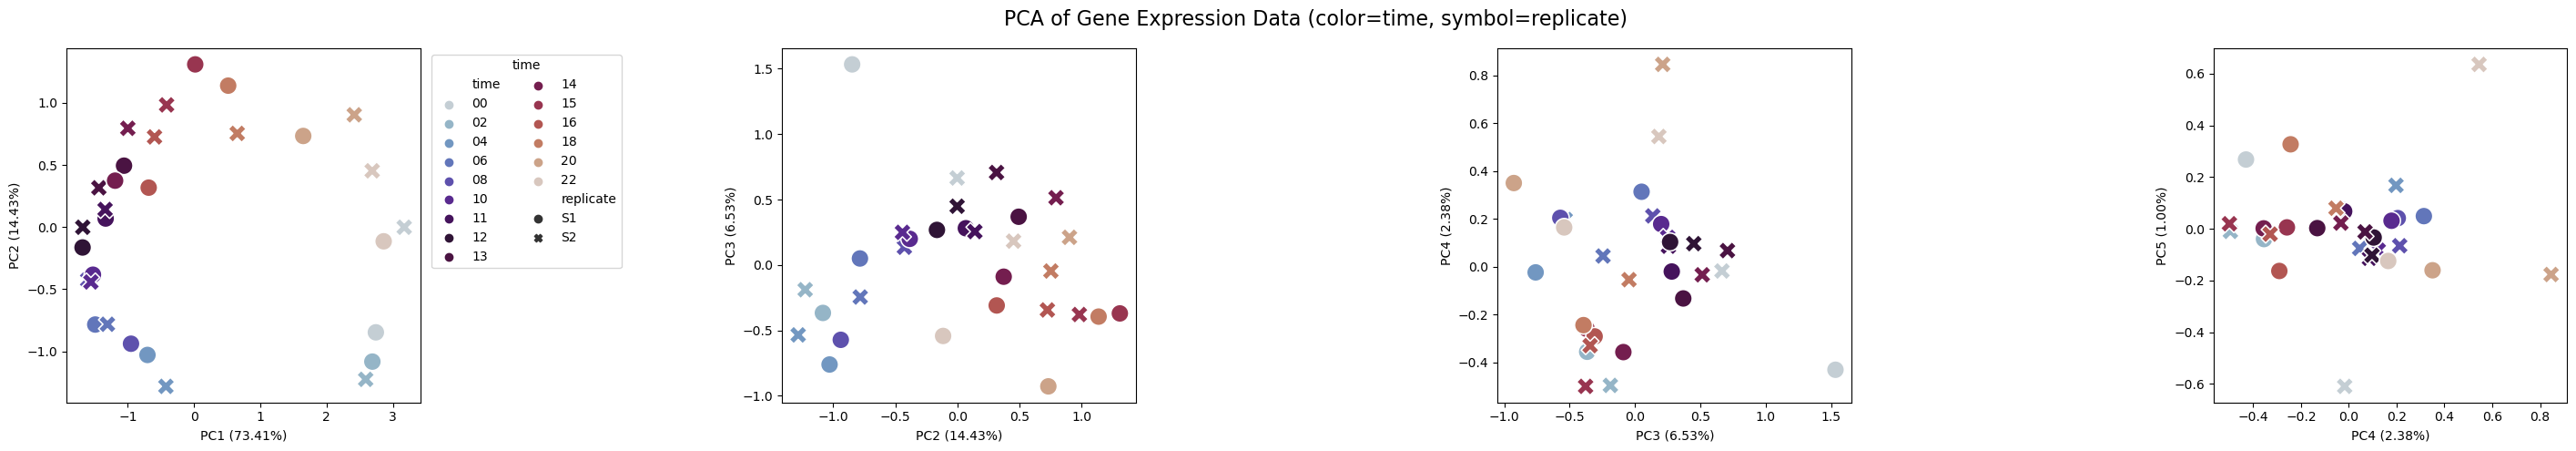

In [131]:
pca_muscle_intron = run_PCA(dat_intron_muscle.loc[circa_genes], color_by='time', symbol_by='replicate')

As we can see the two experiments show similar pattern of circle on the PCA1/PCA2 plot. The different time point follow a circle path in a chronological order (the time series that are close in time modulo $\omega$ appear next to each other).
This show a clear pattern of rythmic expression which would the expected behaviour for a circadian rythm.

#### Assess gene expression rhythmicity genome-wide

In [132]:
# Apply the function to both intron and exon data for both tissues
T = 24
time = dat_exon_liver.columns.get_level_values('time').str.replace('ZT','').astype(int)

results_intron_liver = fit_harmo(dat_intron_liver, time, T)
results_exon_liver = fit_harmo(dat_exon_liver, time, T)
results_intron_muscle = fit_harmo(dat_intron_muscle, time, T)
results_exon_muscle = fit_harmo(dat_exon_muscle, time, T)

/Users/gregoirepachebat/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


#### Define the genes of interest

In [ ]:
# Define the genes with significant gene expression rhythm in the liver
gene_liver_intro = np.logical_and(results_intron_liver['q_val'] < 0.05, results_intron_liver['amp'] > 0.5)
gene_liver_exon = np.logical_and(results_exon_liver['q_val'] < 0.05, results_exon_liver['amp'] > 0.5)

# Define the genes with significant gene expression rhythm in the muscle
gene_muscle_intro = np.logical_and(results_intron_muscle['q_val'] < 0.05, results_intron_muscle['amp'] > 0.5)
gene_muscle_exon = np.logical_and(results_exon_muscle['q_val'] < 0.05, results_exon_muscle['amp'] > 0.5)

print(len(gene_liver_intro))


#### Plot phase and amplitude distribution for the rhythmic genes

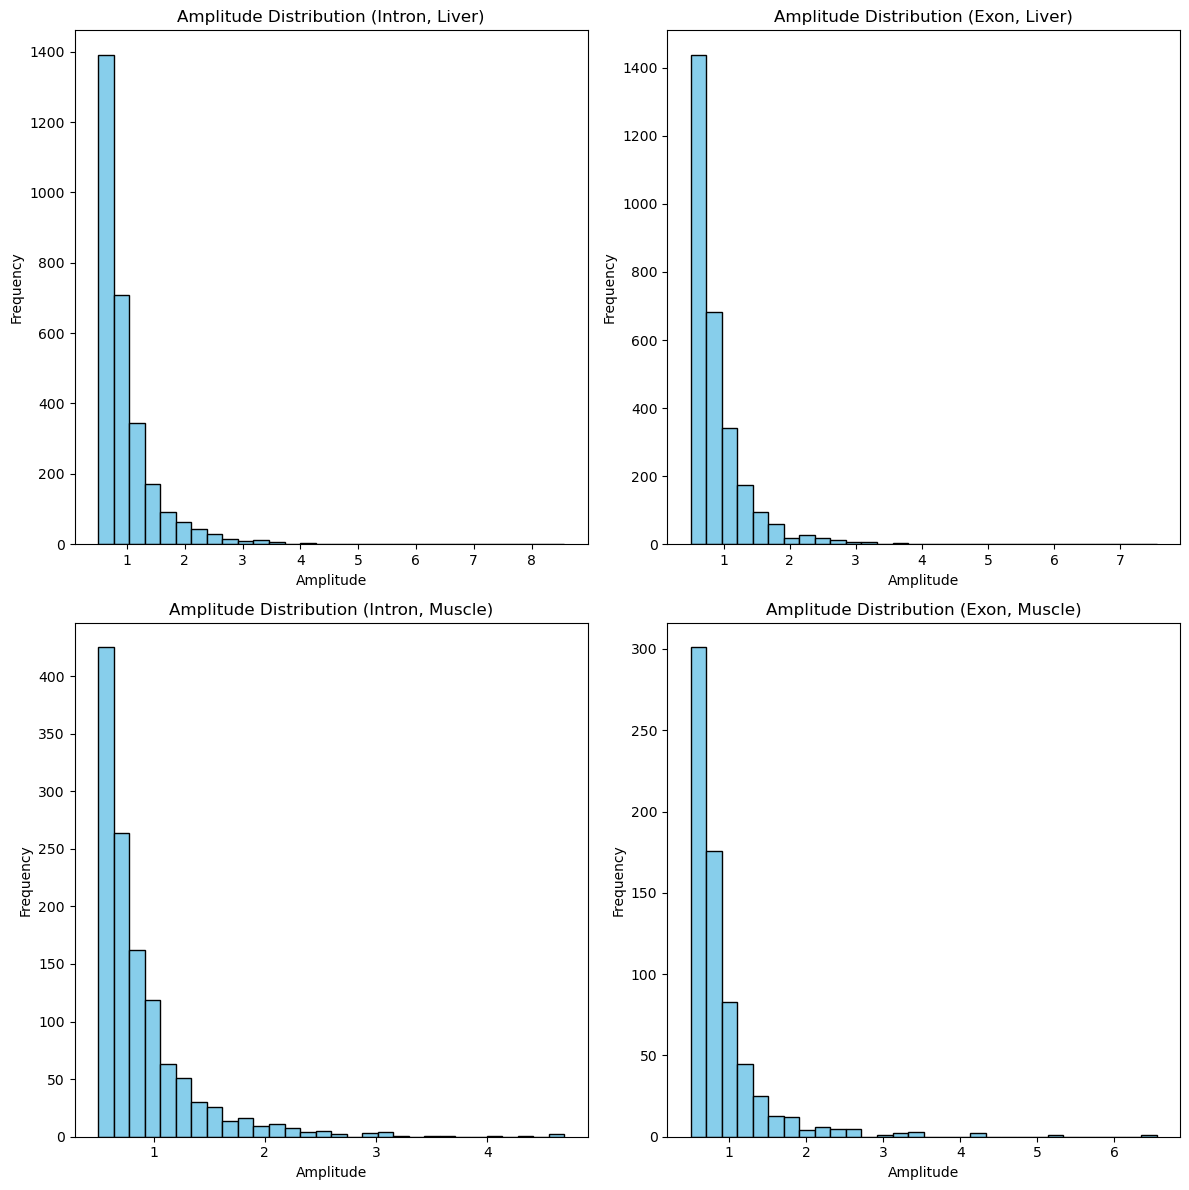

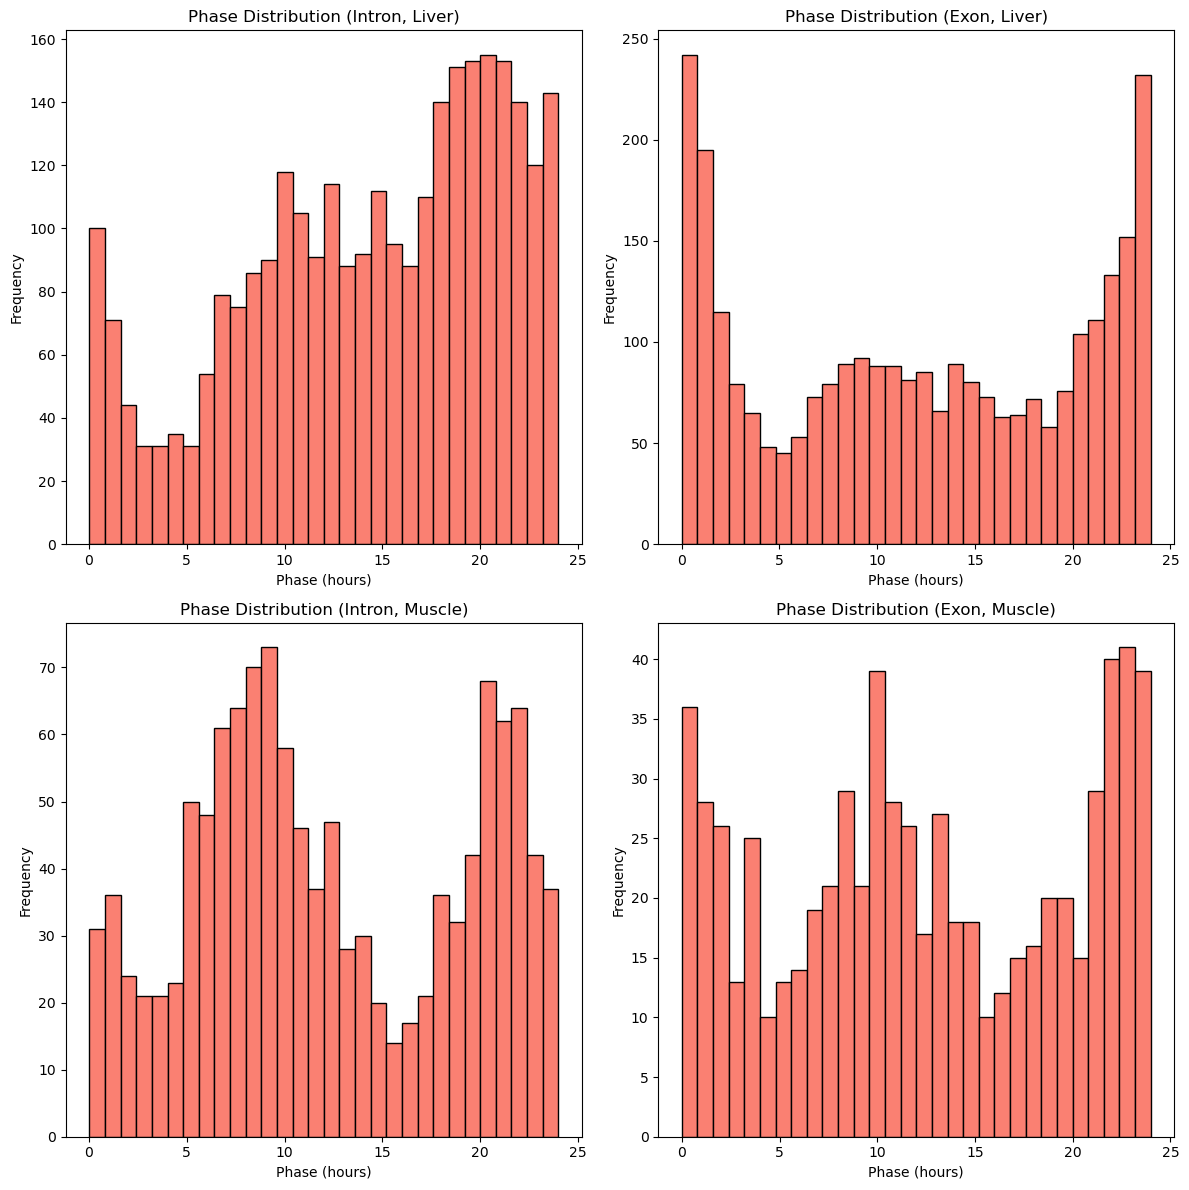

In [135]:
# Filter the results for the genes of interest
filtered_results_liver_intron = results_intron_liver[gene_liver_intro]
filtered_results_liver_exon = results_exon_liver[gene_liver_exon]
filtered_results_muscle_intron = results_intron_muscle[gene_muscle_intro]
filtered_results_muscle_exon = results_exon_muscle[gene_muscle_exon]

# Plot amplitude distributions
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.hist(filtered_results_liver_intron['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Intron, Liver)')

plt.subplot(2, 2, 2)
plt.hist(filtered_results_liver_exon['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Exon, Liver)')

plt.subplot(2, 2, 3)
plt.hist(filtered_results_muscle_intron['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Intron, Muscle)')

plt.subplot(2, 2, 4)
plt.hist(filtered_results_muscle_exon['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Exon, Muscle)')

plt.tight_layout()
plt.show()

# Plot phase distributions
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.hist(filtered_results_liver_intron['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Intron, Liver)')

plt.subplot(2, 2, 2)
plt.hist(filtered_results_liver_exon['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Exon, Liver)')

plt.subplot(2, 2, 3)
plt.hist(filtered_results_muscle_intron['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Intron, Muscle)')

plt.subplot(2, 2, 4)
plt.hist(filtered_results_muscle_exon['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Exon, Muscle)')

plt.tight_layout()
plt.show()
#

We can clearly see pattern of expression. The phase distribution show that waves of gene activate themselves only at certain time.

### Question 2

1. Related to Exercise 1, study the relationship between the peak times (i.e., phase) of pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels in each tissue independently. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis.  
   **Hint:** Show a scatter plot of mRNA vs. pre-mRNA peak times. Explain your findings.

2. Show representative profiles of genes with short or long delays between the pre-mRNA and mRNA peak times.

3. From the delay between the pre-mRNA and mRNA ($\delta t$ [hr]), infer the mRNA half-life ($\tau$ [hr]) using the formula derived in the course:  


   $$\tan\left(\frac{2\pi \cdot \delta t}{24}\right) = \frac{24}{2\pi}  \frac{ \tau}{\ln(2)}$$
 

   Plot the histogram of the inferred mRNA half-lives for each tissue. Explain your findings.

4. For the selected genes that are common between muscle and liver, compare their mRNA half-lives. Show representative profiles of genes with tissue-specific half-lives. 

5. **(Bonus):** What can you infer about the splicing rate?  





#### Plot pre-mRNA, mRNA delay

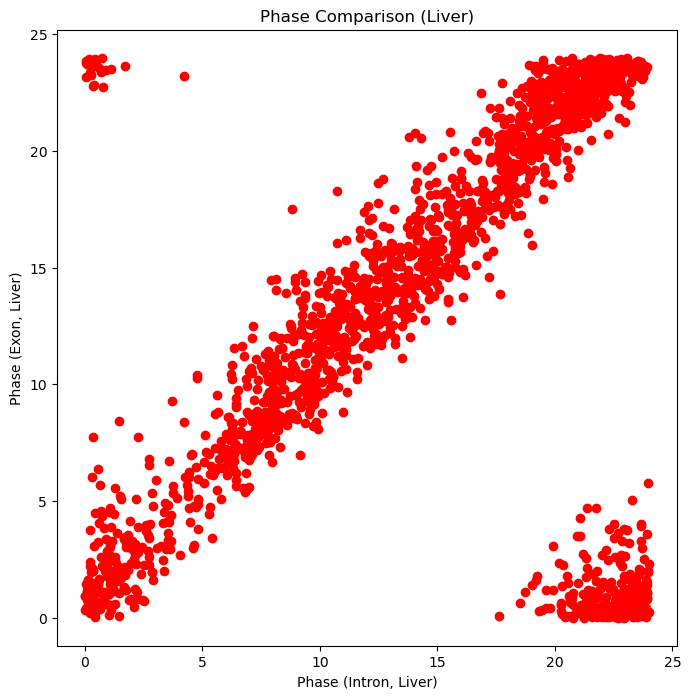

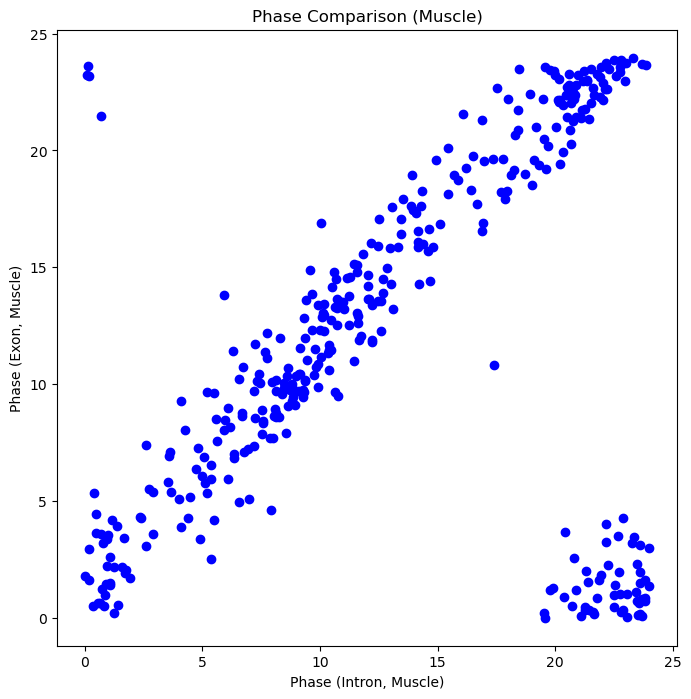

1810
378
11405
11405


In [ ]:

#plot phase intron vs phase exon for gene_liver
#...
# scatter plot of phase intron vs phase exon for liver genes
gene_liver = np.logical_and(gene_liver_intro, gene_liver_exon)
refiltered_results__intron_liver = results_intron_liver[gene_liver]
refiltered_results__exon_liver = results_exon_liver[gene_liver]
plt.figure(figsize=(8, 8))
plt.scatter(refiltered_results__intron_liver['phase'], refiltered_results__exon_liver['phase'], color='red')
plt.xlabel('Phase (Intron, Liver)')
plt.ylabel('Phase (Exon, Liver)')
plt.title('Phase Comparison (Liver)')
plt.show()

#plot phase intron vs phase exon
#...
#...
gene_muscle = np.logical_and(gene_muscle_intro, gene_muscle_exon)
refiltered_results__intron_muscle = results_intron_muscle[gene_muscle]
refiltered_results__exon_muscle = results_exon_muscle[gene_muscle]

# scatter plot of phase intron vs phase exon for muscle genes
plt.figure(figsize=(8, 8))
plt.scatter(refiltered_results__intron_muscle['phase'], refiltered_results__exon_muscle['phase'], color='blue')
plt.xlabel('Phase (Intron, Muscle)')
plt.ylabel('Phase (Exon, Muscle)')
plt.title('Phase Comparison (Muscle)')
plt.show()

### Answer 1
As we plot the phase for the intron and the phase for the exon, a clear pattern appear : a line appear with coefficient one and two cluster around the corners of the graph.  
The line show that the peak expression times of the intron and the exon of the genes have the same expression time. The cluster on the corners are due to the fact that the phase is computed modulo 24h. The genes in these cluster also have a similar peak time.  
We can also see a higher density of point around the points (modulo 24 hour) $(0,0)$ and $(12,12)$. This is in correlation with the previous results showing a high frequency of genes having peak times around those points. 

### Plot representative genes with short or long-delay

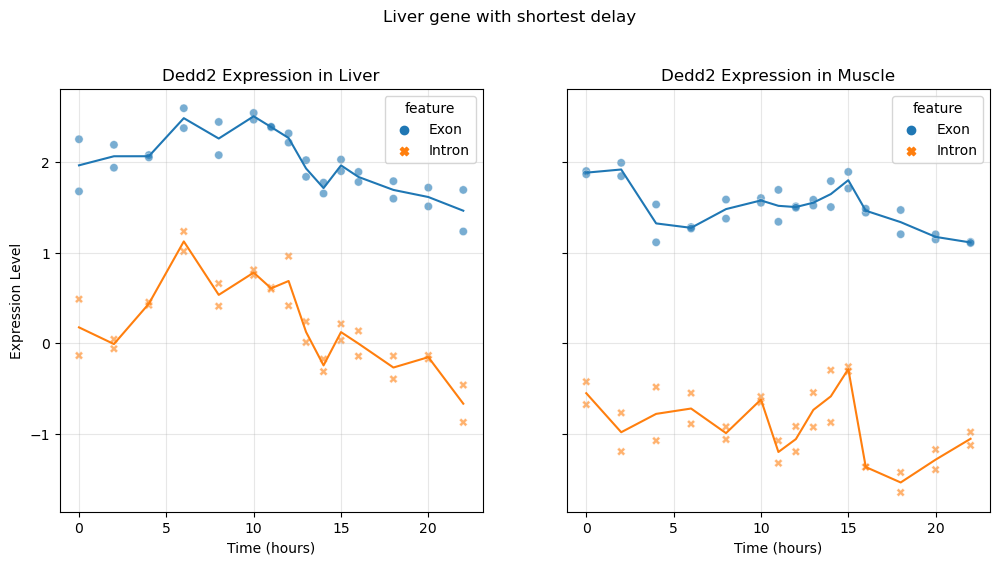

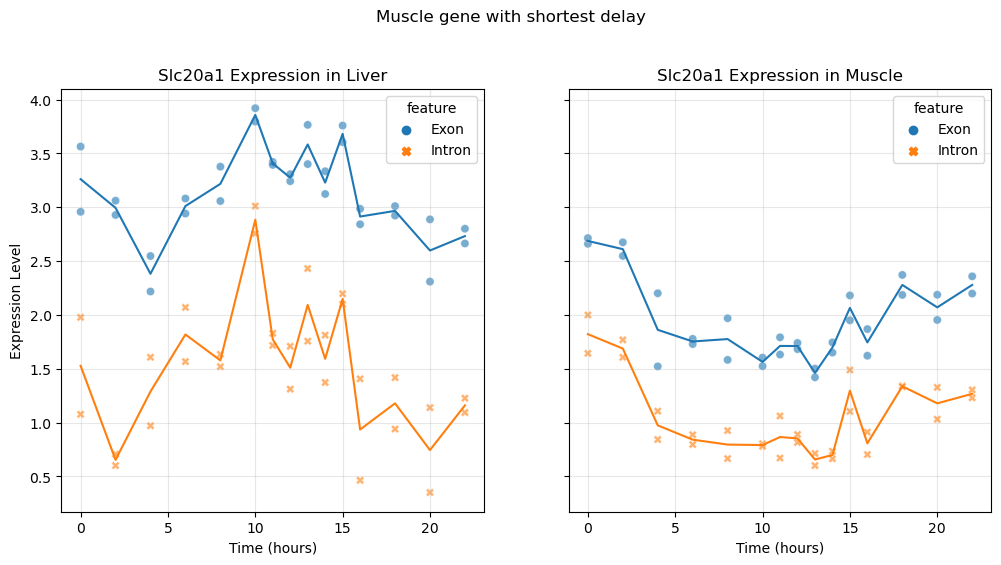

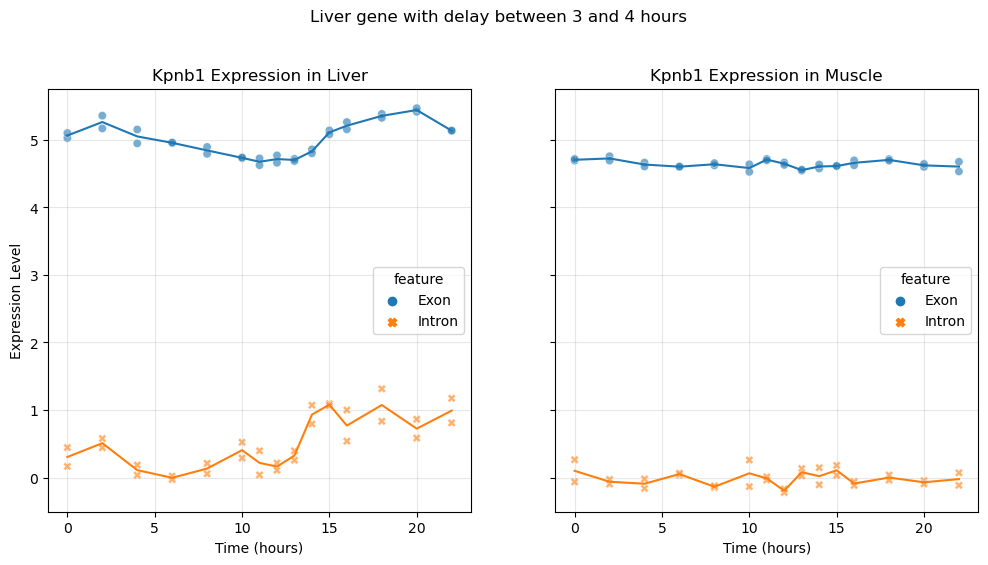

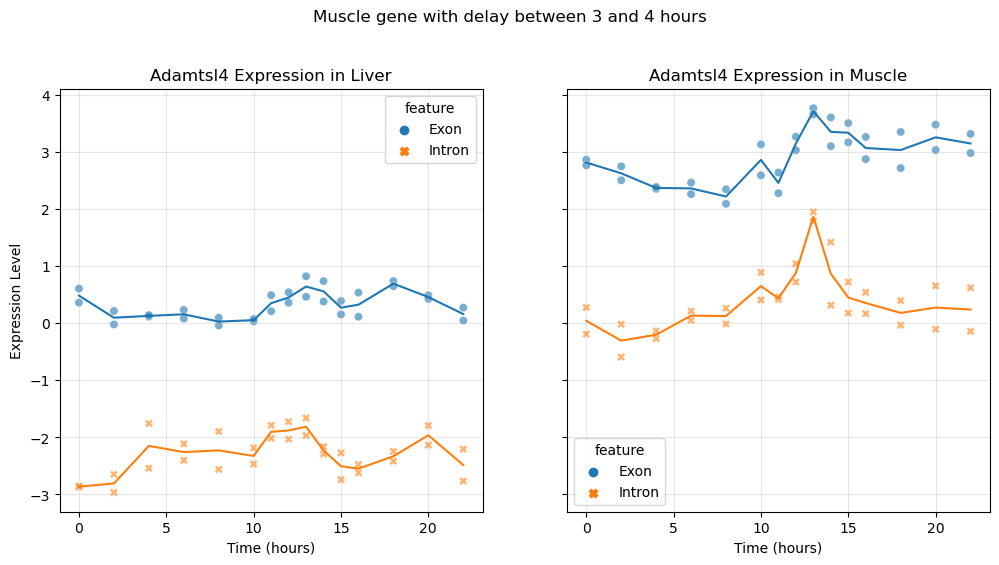

In [143]:
#compute the delay between intron and exon for liver and muscle
#restrict to genes with phase difference < 6 hours and with exon later than intron
liver_phase_diff = refiltered_results__exon_liver['phase'] - refiltered_results__intron_liver['phase']
muscle_phase_diff = refiltered_results__exon_muscle['phase'] - refiltered_results__intron_muscle['phase']

# restrict to genes with phase difference < 6 hours and with exon later than intron
liver_phase_diff = liver_phase_diff[(liver_phase_diff < 6) & (liver_phase_diff > 0)]
muscle_phase_diff = muscle_phase_diff[(muscle_phase_diff < 6) & (muscle_phase_diff > 0)]

#find gene with shortest delay in muscle and liver, plot representative gene expression
#plot_gene_expression(dat_melted, "GeneName")
min_liver = liver_phase_diff.idxmin()
min_muscle = muscle_phase_diff.idxmin()

plot_gene_expression(dat_melted, min_liver, title = 'Liver gene with shortest delay')
plot_gene_expression(dat_melted, min_muscle, title='Muscle gene with shortest delay')

#find gene with delay between 3 and 4 hours in muscle and liver
#plot_gene_expression(dat_melted, "GeneName")
genes_between_3_and_4_liver = liver_phase_diff[(liver_phase_diff > 3) & (liver_phase_diff < 4)].index
genes_between_3_and_4_muscle = muscle_phase_diff[(muscle_phase_diff > 3) & (muscle_phase_diff < 4)].index

plot_gene_expression(dat_melted, genes_between_3_and_4_liver[2], title = 'Liver gene with delay between 3 and 4 hours')
plot_gene_expression(dat_melted, genes_between_3_and_4_muscle[2], title='Muscle gene with delay between 3 and 4 hours')
    

### Answer 2
There is no seenable difference between the expression pattern of intron/exon in the genes with low phase difference and high phase difference.

### Compute half-life from the delay between intron and exon


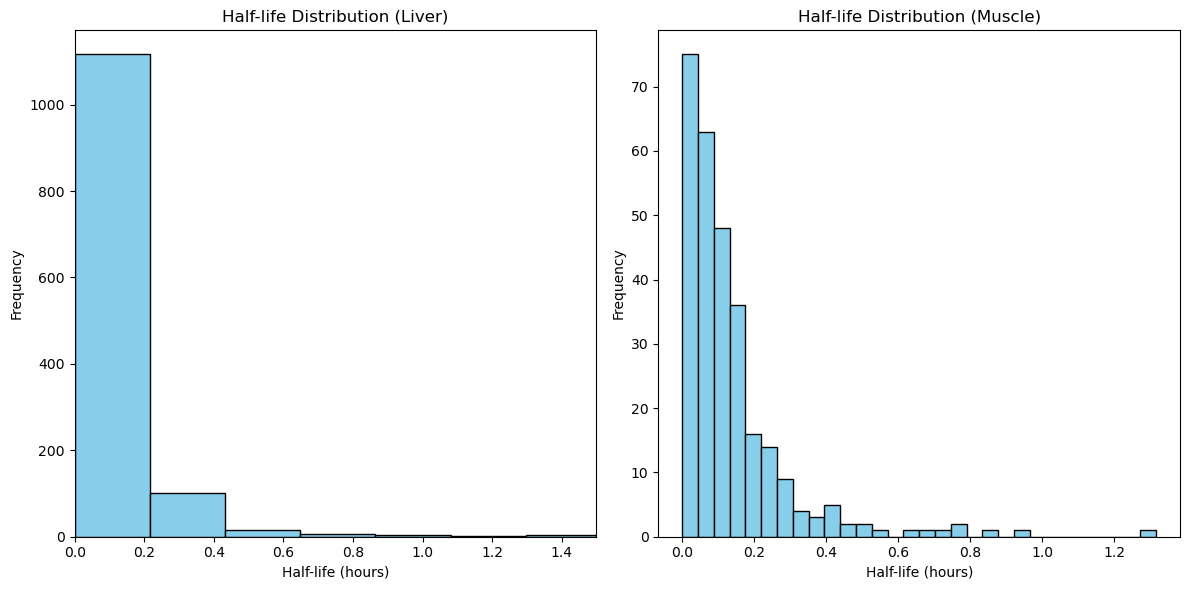

In [158]:
half_life_liver = (np.pi/12)*np.log(2) * np.tan((np.pi/12)*liver_phase_diff)
half_life_muscle = (np.pi/12)*np.log(2) * np.tan((np.pi/12)*muscle_phase_diff)

# Plot the half-lives
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(half_life_liver, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Half-life (hours)')
plt.ylabel('Frequency')
plt.xlim(0,1.5)
plt.title('Half-life Distribution (Liver)')
plt.subplot(1, 2, 2)
plt.hist(half_life_muscle, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Half-life (hours)')
plt.ylabel('Frequency')
plt.title('Half-life Distribution (Muscle)')
plt.tight_layout()
plt.show()


### Answer 3
The histograms of the inferred mRNA half-lives for liver and muscle tissues show distinct distributions. In the liver, the half-lives are generally shorter, with a peak around 0.1 hours, indicating rapid mRNA turnover. In contrast, the muscle tissue exhibits a broader distribution of half-lives, with a significant number of genes having longer half-lives, suggesting more stable mRNA.

This difference in mRNA stability between liver and muscle tissues could be attributed to the distinct functional roles and metabolic activities of these tissues. The liver, being a central metabolic organ, may require rapid mRNA turnover to quickly respond to metabolic changes. On the other hand, muscle tissue, which is involved in sustained physical activity, might benefit from more stable mRNA to maintain consistent protein synthesis.

Overall, these findings highlight the tissue-specific regulation of mRNA stability, which is crucial for the proper functioning of different organs.

### Compare half-lives between muscle and liver

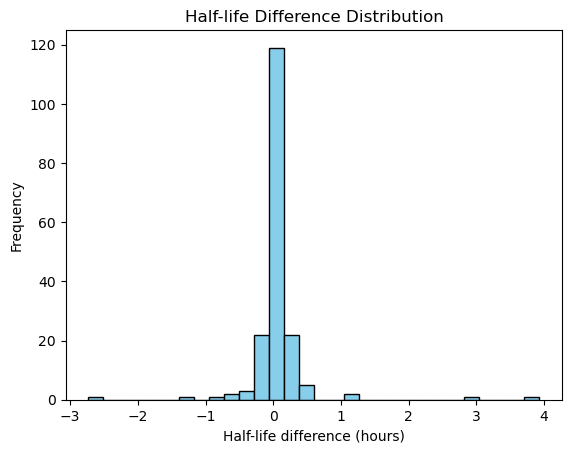

In [140]:
half_life_diff = half_life_muscle - half_life_liver

# plot the histogram of half-life differences
plt.hist(half_life_diff, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Half-life difference (hours)')
plt.ylabel('Frequency')
plt.title('Half-life Difference Distribution')
plt.show()


### Answer 3
This graph show that most genes have the same expression pattern in the muslces and in the liver : we can see a clear peak centered around 0 meaning that the phase difference (i.e. the difference of peak expression time) has no difference (or very little) for the majority of the genes. 

### Plot representative genes with tissue-specific half-life

In [141]:
specific_half_life_gene = half_life_diff[np.abs(half_life_diff)>1].index

print(specific_half_life_gene)
 

Index(['Asb2', 'Fmnl2', 'Gm49601', 'Myh10', 'Pdcd4', 'Relt'], dtype='object', name='gene.symb')


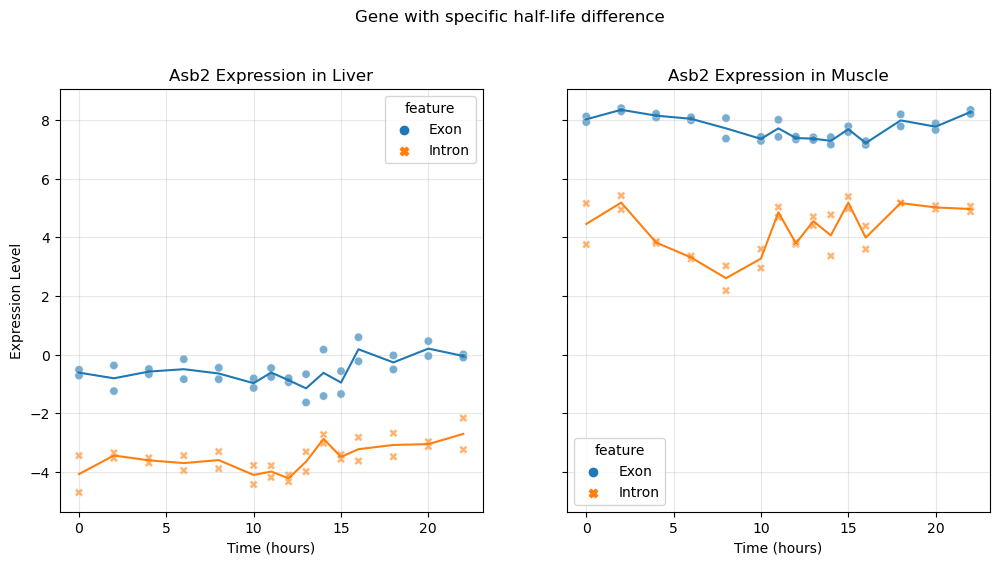

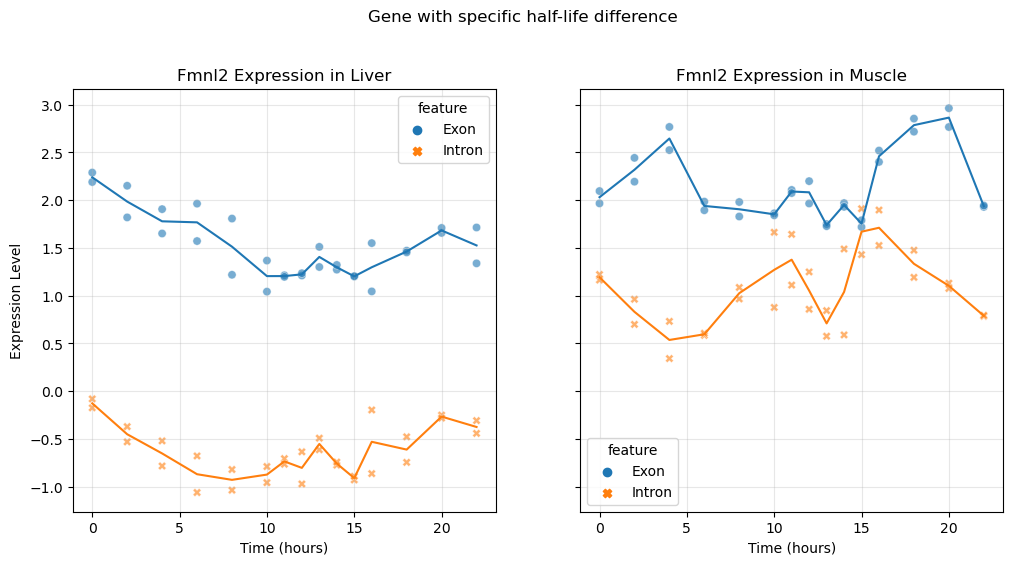

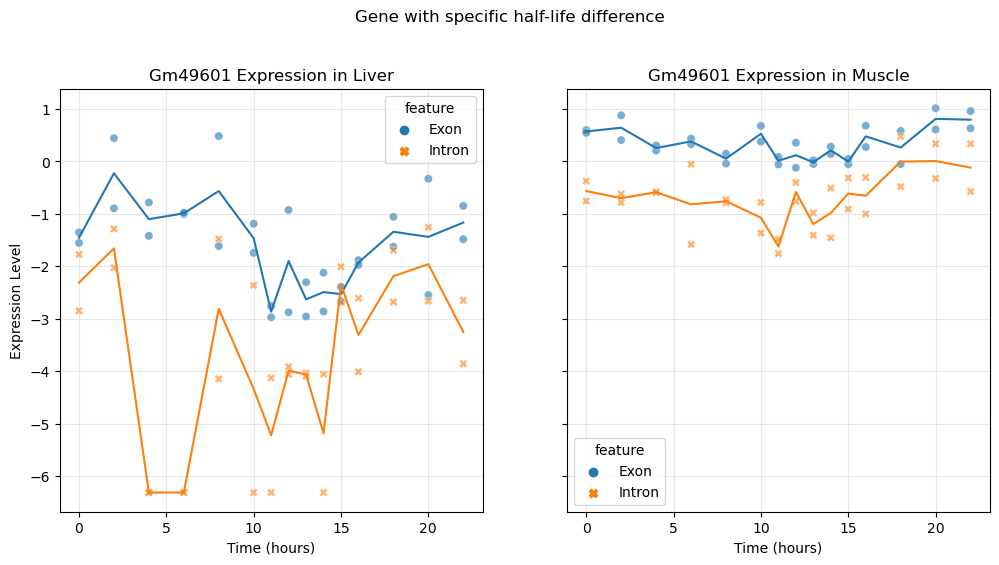

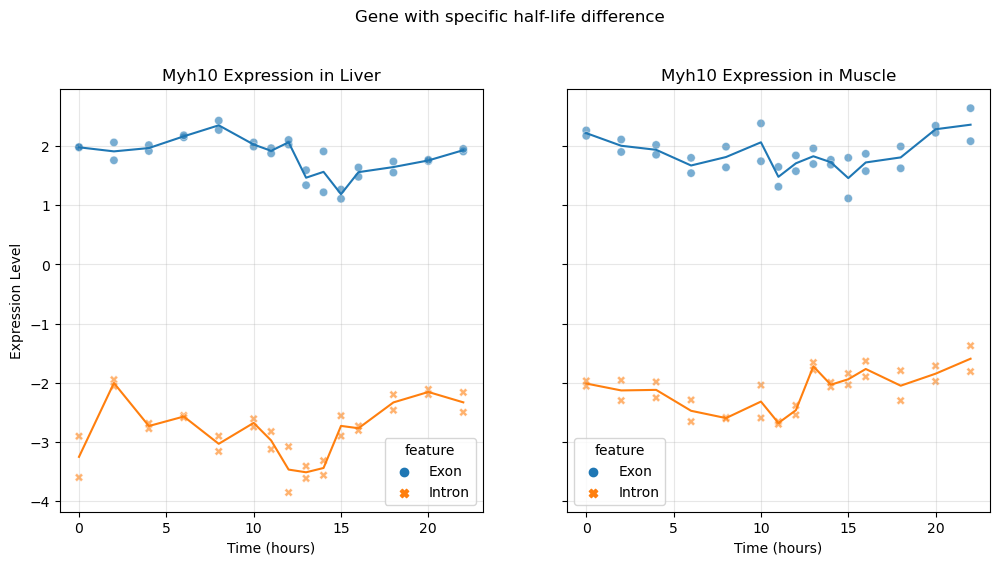

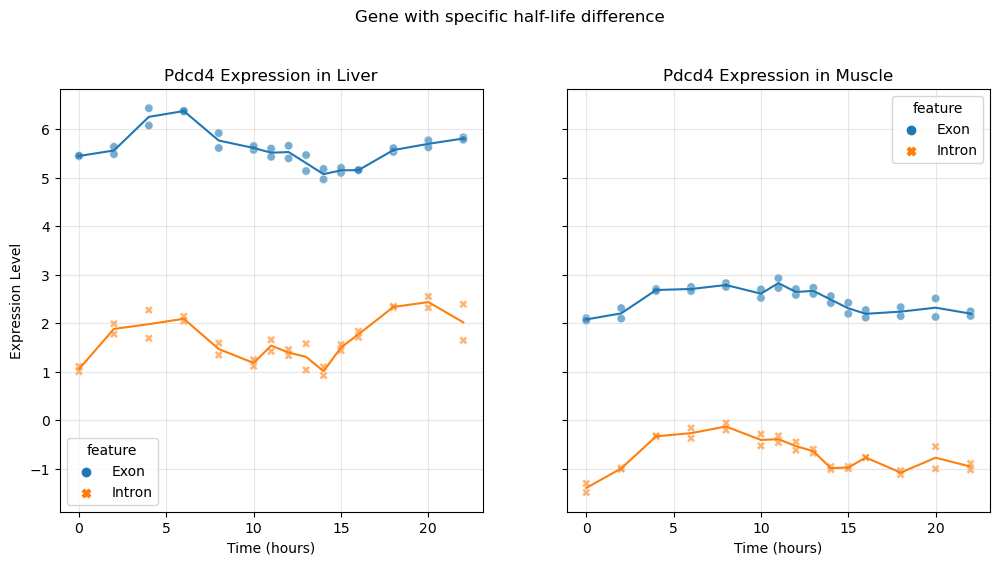

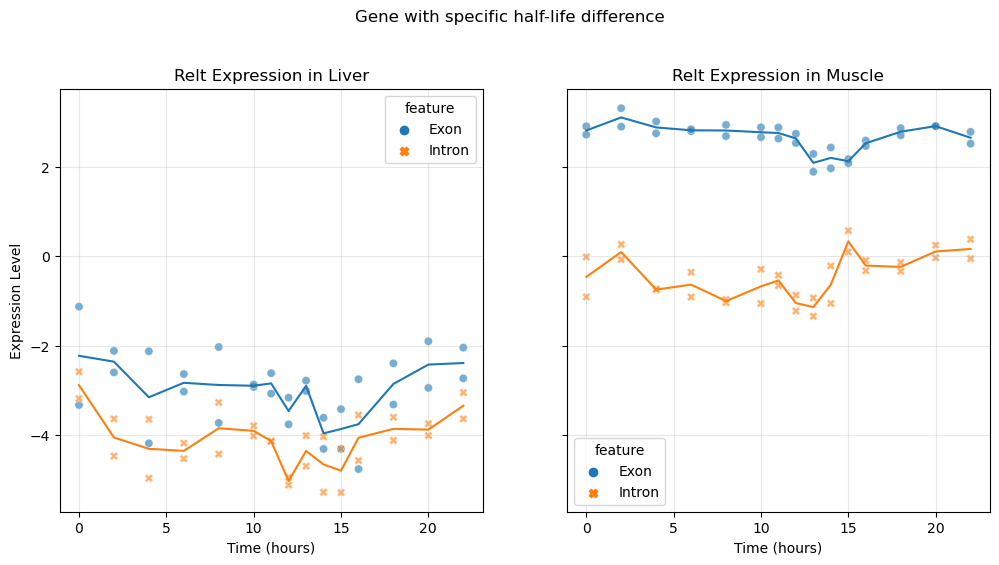

In [155]:
for i in range(len(specific_half_life_gene)):
    plot_gene_expression(dat_melted, specific_half_life_gene[i], title='Gene with specific half-life difference')